In [277]:
import scipy.signal
import pandas as pd
from scipy.signal import savgol_filter

def vel_filter(ang_vel_all):
    b, a = scipy.signal.butter(2, 0.1, 'lowpass')
    # b, a = scipy.signal.butter(5, 0.05, 'lowpass')
    # b, a = scipy.signal.butter(N=5, Wn=33, fs=200, btype='lowpass', analog=False)
    return scipy.signal.filtfilt(b, a, ang_vel_all)

data = pd.read_csv('GazeDataPilot\gaze_data_all_trials_y_pilot_no_ramp_jenna_2.csv', sep=',')
trial_details_df = pd.read_csv("generated_trials_ids_y_pilot_no_ramp.csv")

In [278]:
import numpy as np
import matplotlib.pyplot as plt

# Map TrialID to camera motion type and object speed based on an external mapping file
def map_camera_motion_type_and_object_speed(data_df, trial_details_df):
    data_df = data_df.merge(trial_details_df[['trial_id', 'camera_motion_type', 'object_speed', 'camera_speed', 'object_motion_type']],
                            left_on='TrialID', right_on='trial_id', how='left')
    return data_df

# Screen resolution
screen_width = 2560
screen_height = 1440

# Process data
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())
data['MappedPogX'] = data['BestPogX'] * screen_width
data['MappedPogY'] = data['BestPogY'] * screen_height
data[['BallX', 'BallY']] = data['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
data = data[(data['BallX'] >= 0) & (data['BallY'] >= 0)]
data = map_camera_motion_type_and_object_speed(data, trial_details_df)

# Apply the filter to each trial individually
def apply_filter_per_trial(df, column_name, new_column_name):
    df[new_column_name] = (
        df.groupby('TrialNumber')[column_name]
        .transform(lambda x: vel_filter(x.fillna(0)))
    )
    return df

# Smooth raw positional values for each trial
data = apply_filter_per_trial(data, 'MappedPogX', 'FilteredPogX')
data = apply_filter_per_trial(data, 'MappedPogY', 'FilteredPogY')
# data['FilteredPogX'] = data['MappedPogX'].fillna(0)
# data['FilteredPogY'] = data['MappedPogY'].fillna(0)

In [279]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data structure to organize pair conditions
pair_conditions = {
    "diagonal_with_y1": {
        "left_to_right": ["diagonal_left_up_y1", "diagonal_left_down_y1"],
        "right_to_left": ["diagonal_right_up_y1", "diagonal_right_down_y1"]
    },
    "diagonal_against_y1": {
        "left_to_right": ["diagonal_right_up_y1", "diagonal_right_down_y1"],
        "right_to_left": ["diagonal_left_up_y1", "diagonal_left_down_y1"]
    },
    "diagonal_with_y2": {
        "left_to_right": ["diagonal_left_up_y2", "diagonal_left_down_y2"],
        "right_to_left": ["diagonal_right_up_y2", "diagonal_right_down_y2"]
    },
    "diagonal_against_y2": {
        "left_to_right": ["diagonal_right_up_y2", "diagonal_right_down_y2"],
        "right_to_left": ["diagonal_left_up_y2", "diagonal_left_down_y2"]
    },
    "vertical": {
        "left_to_right": ["vertical_up", "vertical_down"],
        "right_to_left": ["vertical_up", "vertical_down"]
    },
    "horizontal_with": {
        "left_to_right": ["horizontal_left"],
        "right_to_left": ["horizontal_right"]
    },
    "horizontal_against": {
        "left_to_right": ["horizontal_right"],
        "right_to_left": ["horizontal_left"]
    },
    "zero": {
        "left_to_right": ["zero"],
        "right_to_left": ["zero"],
        # "up": ["zero"],
        # "down": ["zero"],
    }
}


In [280]:
def compute_position_dependent_angular_error(df, screen_width, screen_height, screen_diagonal_size, distance_to_screen):
    # Convert screen diagonal size to pixels
    diagonal_resolution = np.sqrt(screen_width**2 + screen_height**2)
    pixel_size = diagonal_resolution / screen_diagonal_size  # Pixels per inch
    distance_to_screen_pixels = distance_to_screen * pixel_size * 39.37  # Convert meters to inches

    # Compute screen center
    screen_center_x = screen_width / 2
    screen_center_y = screen_height / 2

    # Compute distances
    df['PixelDistance'] = np.sqrt((df['FilteredPogX'] - df['BallX'])**2 + (df['FilteredPogY'] - df['BallY'])**2)
    df['TargetToCenterDistance'] = np.sqrt((df['BallX'] - screen_center_x)**2 + (df['BallY'] - screen_center_y)**2)

    # Adjust distance to screen based on target's position on screen
    df['DistanceToScreenAdjusted'] = np.sqrt(distance_to_screen_pixels**2 + df['TargetToCenterDistance']**2)

    # Compute angular error
    df['AngularError'] = np.degrees(np.arctan(df['PixelDistance'] / df['DistanceToScreenAdjusted']))
    
    return df

screen_width = 2560
screen_height = 1440
screen_diagonal_size = 27.5  # inches
distance_to_screen = 0.5842  # meters

# Assuming df has been processed with compute_accuracy
data = compute_position_dependent_angular_error(data, screen_width, screen_height, screen_diagonal_size, distance_to_screen)

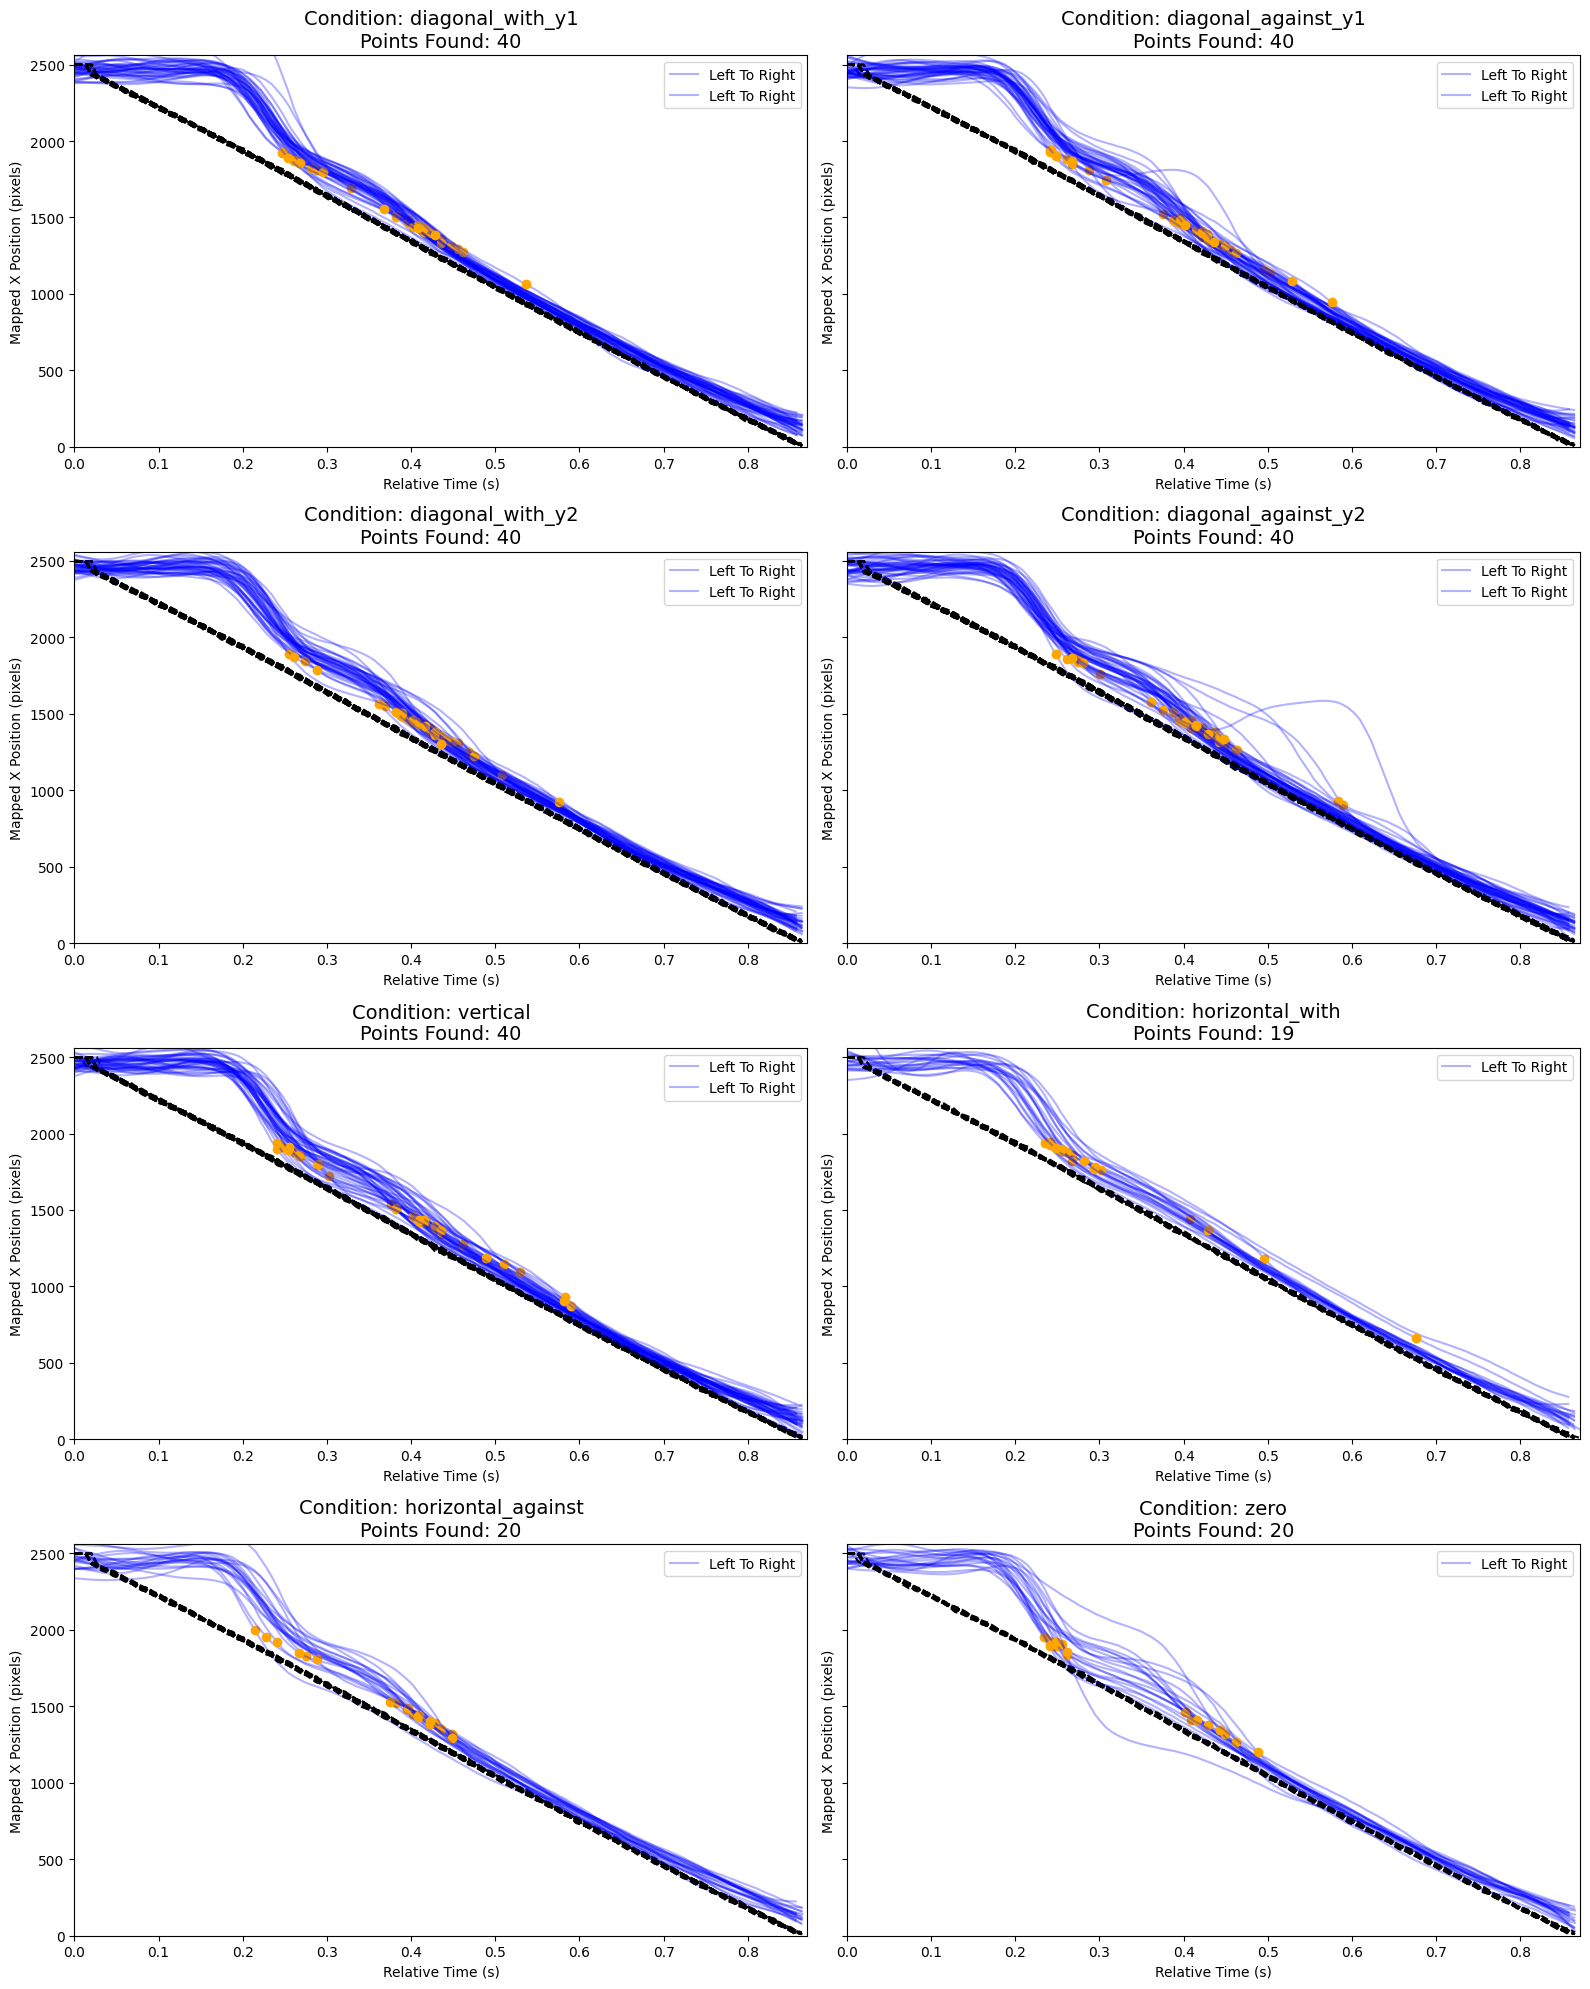

In [281]:
import matplotlib.pyplot as plt
import numpy as np

def get_matching_trials(condition, pair_conditions, trial_details_df, obj_speed, cam_speed):
    matching_trials = {'left_to_right': [], 'right_to_left': [], 'down': [], 'up': []}
    for _, trial in trial_details_df.iterrows():
        object_motion = trial['object_motion_type']
        camera_motion = trial['camera_motion_type']
        
        # Check if the trial matches the left_to_right or right_to_left condition with the specified speeds
        if trial['object_speed'] == obj_speed and trial['camera_speed'] == cam_speed:
            for direction, motion_types in pair_conditions[condition].items():
                if object_motion == direction and camera_motion in motion_types:
                    matching_trials[direction].append(trial['trial_id'])
    return matching_trials

def find_first_within_angular_threshold(df, angular_threshold, time_threshold):
    # Filter rows to only consider those after the time threshold
    df['WithinThreshold'] = (df['AngularError'] <= angular_threshold) & (df['RelativeTime'] > time_threshold)

    # Find the first index where the condition is met for each trial
    df['FirstWithinThreshold'] = df.groupby('TrialNumber')['WithinThreshold'].transform(
        lambda x: x.idxmax() if x.any() else np.nan
    )
    return df

def plot_condition_speed_pairs_with_threshold(
    df, pair_conditions, trial_details_df, angular_threshold, time_passed_seconds, alpha=0.6
):
    # Colors for different directions
    direction_colors = {'left_to_right': 'blue', 'right_to_left': 'red', 'up': 'green', 'down': 'orange'}

    # Get unique object speeds and camera speeds
    obj_speeds = sorted(trial_details_df['object_speed'].unique())
    cam_speeds = sorted(trial_details_df['camera_speed'].unique())

    # Identify valid conditions
    valid_conditions = []
    for condition in pair_conditions:
        condition_found = any(
            trial_details_df['camera_motion_type'].isin(pair_conditions[condition].get(direction, [])).any()
            for direction in pair_conditions[condition]
        )
        if condition_found:
            valid_conditions.append(condition)

    # Create a figure with subplots for valid conditions
    num_conditions = len(valid_conditions)
    num_rows = (num_conditions + 1) // 2  # Determine rows needed for 2 columns
    fig, axes = plt.subplots(num_rows, 2, figsize=(16, 5 * num_rows), sharex=False, sharey=True)
    axes = axes.flatten()  # Flatten for easy indexing

    for idx, condition in enumerate(valid_conditions):
        ax = axes[idx]  # Get the subplot for this condition

        total_trials = 0
        points_found = 0

        for cam_speed in cam_speeds:
            for obj_speed in obj_speeds:
                # Get matching trial IDs for left_to_right and right_to_left based on the condition and speeds
                matching_trials = get_matching_trials(
                    condition, pair_conditions, trial_details_df, obj_speed, cam_speed
                )

                # Check if there are any matching trials; skip if none
                if not any(matching_trials.values()):
                    continue

                # Plot trials for each direction in the same subplot
                for direction, trial_ids in matching_trials.items():
                    color = direction_colors[direction]  # Set color based on direction
                    for trial_id in trial_ids:
                        total_trials += 1  # Increment the total trial count
                        # Filter data for the current trial ID and make a copy
                        trial_data = df[df['TrialID'] == trial_id].copy()

                        # Flip X positions only for right_to_left direction
                        if direction == 'right_to_left':
                            trial_data['FilteredPogX'] = -trial_data['FilteredPogX'] + screen_width
                            trial_data['BallX'] = -trial_data['BallX'] + screen_width

                        # Plot each individual trial in the direction
                        for trial_num in trial_data['TrialNumber'].unique():
                            single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]
                            ax.plot(
                                single_trial_data['RelativeTime'],
                                single_trial_data['FilteredPogX'],
                                color=color,
                                label=f"{direction.replace('_', ' ').title()}"
                                if trial_num == trial_data['TrialNumber'].unique()[0]
                                else "",
                                alpha=alpha,
                            )

                            # Plot the absolute object position X as black dashed lines
                            ax.plot(
                                single_trial_data['RelativeTime'],
                                single_trial_data['BallX'],
                                color='black',
                                linestyle='--',
                            )

                            # Plot the first point within the angular threshold
                            first_index = single_trial_data['FirstWithinThreshold'].iloc[0]
                            if not np.isnan(first_index):
                                points_found += 1  # Increment points found count
                                first_point = single_trial_data.loc[first_index]
                                ax.plot(
                                    first_point['RelativeTime'],
                                    first_point['FilteredPogX'],
                                    'o',
                                    color='orange',
                                )

        # Add the counts to the subplot title
        ax.set_title(
            f"Condition: {condition}\nPoints Found: {points_found}",
            fontsize=14,
        )
        ax.set_xlabel("Relative Time (s)")
        ax.set_ylabel("Mapped X Position (pixels)")
        ax.set_xlim(0, df['RelativeTime'].max())
        ax.set_ylim(-0, screen_width)
        ax.legend()

    # Hide unused subplots
    for idx in range(len(valid_conditions), len(axes)):
        axes[idx].axis('off')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


# Preprocess data to find points within angular threshold
angular_threshold = 3.0  # Degrees
time_passed_seconds = 0.15
data = find_first_within_angular_threshold(data, angular_threshold, time_passed_seconds)

# Plot pairs with markers for the first point within threshold
plot_condition_speed_pairs_with_threshold(data, pair_conditions, trial_details_df, angular_threshold, time_passed_seconds, alpha=0.3)


obj: 70.0, cam: 70.0


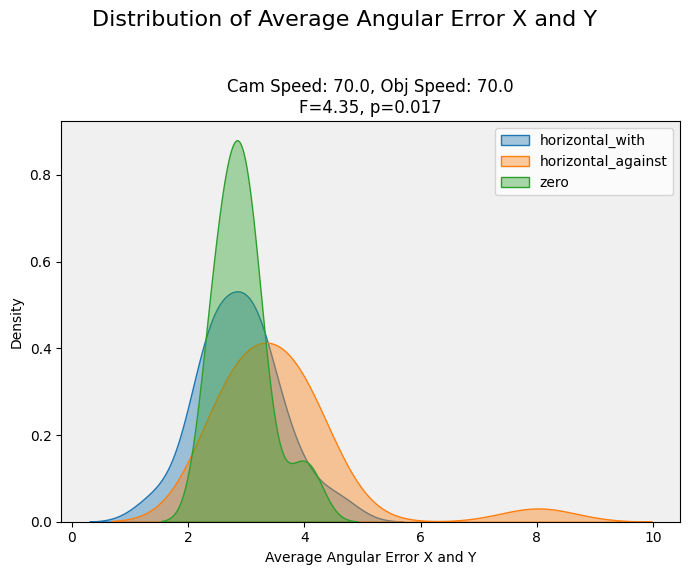

In [275]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns  # For smooth density plots


def classify_combined_motion_type(row, pair_conditions):
    """
    Classify the combined motion type based on the object motion type and direction.
    """
    for pair_name, directions in pair_conditions.items():
        for direction, motion_types in directions.items():
            if row['camera_motion_type'] in motion_types and row['object_motion_type'] == direction:
                return pair_name
    return None  # Return None if no match is found

def calculate_average_error_per_individual_trial(df, 
                                                 time_start=0, 
                                                 time_end=None, 
                                                 object_speed=None, 
                                                 camera_speed=None, 
                                                 object_motion_types=None,
                                                 axis="X"):
    # Filter data based on time and validity
    filtered_df = df[(df['RelativeTime'] >= time_start) & 
                     (df['RelativeTime'] <= (time_end if time_end is not None else df['RelativeTime'].max()))]
    filtered_df = filtered_df[filtered_df['BestPogValid'] == True]

    # Filter based on object and camera speeds
    if object_speed is not None:
        filtered_df = filtered_df[filtered_df['object_speed'] == object_speed]
    if camera_speed is not None:
        filtered_df = filtered_df[np.isclose(filtered_df['camera_speed'], camera_speed, rtol=1)]

    # Adjust for direction for X-axis mappings
    if 'object_motion_type' in df.columns:
        filtered_df.loc[filtered_df['object_motion_type'] == 'right_to_left', 'MappedPogX'] = -filtered_df['MappedPogX'] + screen_width
        filtered_df.loc[filtered_df['object_motion_type'] == 'right_to_left', 'BallX'] = -filtered_df['BallX'] + screen_width

    # Filter based on object motion types
    if object_motion_types is not None and len(object_motion_types) != 0:
        filtered_df = filtered_df[filtered_df['object_motion_type'].isin(object_motion_types)]

    # Add combined motion type column
    filtered_df['camera_combined_motion_types'] = filtered_df.apply(
        classify_combined_motion_type, axis=1, pair_conditions=pair_conditions
    )

    # # Compute pixel error
    # filtered_df['PixelError'] = np.sqrt(
    #     (filtered_df['MappedPogX'] - filtered_df['BallX'])**2 + 
    #     (filtered_df['MappedPogY'] - filtered_df['BallY'])**2
    # )

    # Calculate the average pixel error grouped by combined motion type, TrialID, and TrialNumber
    avg_error_per_individual_trial = filtered_df.groupby(
        ['camera_combined_motion_types', 'TrialID', 'TrialNumber']
    )['AngularError'].mean().reset_index()

    return avg_error_per_individual_trial

# Perform ANOVA on the average error per individual trial run across specified camera motion types
def perform_anova_on_individual_trials(avg_error_per_individual_trial, camera_motion_types=None):
    if camera_motion_types is not None:
        avg_error_per_individual_trial = avg_error_per_individual_trial[avg_error_per_individual_trial['camera_combined_motion_types'].isin(camera_motion_types)]
    
    # Organize the data by camera motion type for ANOVA
    error_data = [avg_error_per_individual_trial[avg_error_per_individual_trial['camera_combined_motion_types'] == motion_type]['AngularError'] 
                  for motion_type in avg_error_per_individual_trial['camera_combined_motion_types'].unique()]
    
    if len(error_data) > 1:
        f_stat, p_value = f_oneway(*error_data)
        return {'F-statistic': f_stat, 'p-value': p_value}
    else:
        return {'F-statistic': None, 'p-value': None}  # Skip ANOVA if only one group

def analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds, object_motion_types, axis):
    num_camera_speeds = len(camera_speeds)
    num_object_speeds = len(object_speeds)
    num_combinations = num_camera_speeds * num_object_speeds

    # Create figure and axes
    if num_combinations > 1:
        fig, axes = plt.subplots(num_camera_speeds, num_object_speeds, figsize=(15, 12), sharex=True, sharey=True)
        fig.suptitle(f"Distribution of Average Angular Error {axis}", fontsize=16)
    else:
        fig, ax = plt.subplots(figsize=(7, 6))
        axes = [[ax]]  # Single plot, wrapped in a nested list to maintain indexing consistency
        fig.suptitle(f"Distribution of Average Angular Error X and Y", fontsize=16)

    for i, cam_speed in enumerate(camera_speeds):
        for j, obj_speed in enumerate(object_speeds):
            time_start, time_end = time_ranges.get(obj_speed, (0, 4))  # Default time range if not in map

            avg_error_per_individual_trial = calculate_average_error_per_individual_trial(
                data, time_start, time_end, object_speed=obj_speed, camera_speed=cam_speed, object_motion_types=object_motion_types, axis=axis
            )
            print(f'obj: {obj_speed}, cam: {cam_speed}')
            anova_results = perform_anova_on_individual_trials(avg_error_per_individual_trial, camera_motion_types=camera_motion_types_to_compare)

            # Get the subplot axes
            ax = axes[i][j] if num_combinations > 1 else axes[0][0]

            # Shade the plot background gray if p-value is significant (p < 0.05)
            p_value = anova_results['p-value']
            if p_value is not None and p_value < 0.05:
                ax.set_facecolor('#f0f0f0')  # Light gray background for significant p-values

            # Plot a density plot of average Angular error per individual trial for each camera motion type
            for motion_type in camera_motion_types_to_compare:
                motion_data = avg_error_per_individual_trial[avg_error_per_individual_trial['camera_combined_motion_types'] == motion_type]
                sns.kdeplot(motion_data['AngularError'], ax=ax, label=f"{motion_type}", fill=True, alpha=0.4)

            # Display ANOVA results in the title of each subplot
            f_stat = anova_results['F-statistic']
            ax.set_title(f"Cam Speed: {cam_speed}, Obj Speed: {obj_speed}\nF={f_stat:.2f}, p={p_value:.3f}")
            ax.set_xlabel("Average Angular Error X and Y")
            ax.set_ylabel("Density")
            ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Define parameters
time_ranges = {
    15.0: (0.2, 5.0),  
    30.0: (0.2, 3.5),
    70.0: (0.2, 0.8),  
}
camera_motion_types_to_compare = [
    # 'diagonal_with_y1', 
    # 'diagonal_with_y2', 
    'horizontal_with',
    # 'diagonal_against_y1', 
    # 'diagonal_against_y2', 
    'horizontal_against',
    'zero', 
    # 'vertical'
    ]
camera_speeds = [70.0] 
object_speeds = [70.0]

object_motion_types = ['left_to_right']  # Specify the object motion types to filter
# Analyze each combination of camera and object speeds
analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds, object_motion_types, "Y")


obj: 70.0, cam: 70.0
3
nan nan


C:\Users\jk8659\AppData\Local\Temp\ipykernel_91444\3342788960.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(time_to_reach_threshold).reset_index(name='TimeToThreshold')


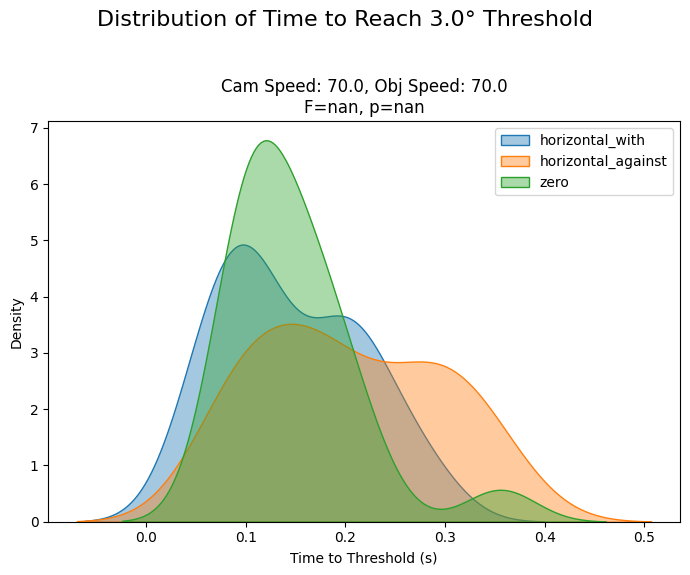

In [276]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns  # For smooth density plots

def classify_combined_motion_type(row, pair_conditions):
    """
    Classify the combined motion type based on the object motion type and direction.
    """
    for pair_name, directions in pair_conditions.items():
        for direction, motion_types in directions.items():
            if row['camera_motion_type'] in motion_types and row['object_motion_type'] == direction:
                return pair_name
    return None  # Return None if no match is found

def calculate_time_to_reach_angular_threshold(df, 
                                              angular_threshold, 
                                              time_start=0, 
                                              time_end=None, 
                                              object_speed=None, 
                                              camera_speed=None, 
                                              object_motion_types=None,
                                              axis="X"):
    # Filter data based on time and validity
    filtered_df = df[(df['RelativeTime'] >= time_start) & 
                     (df['RelativeTime'] <= (time_end if time_end is not None else df['RelativeTime'].max()))]
    filtered_df = filtered_df[filtered_df['BestPogValid'] == True]

    # Filter based on object and camera speeds
    if object_speed is not None:
        filtered_df = filtered_df[filtered_df['object_speed'] == object_speed]
    if camera_speed is not None:
        filtered_df = filtered_df[np.isclose(filtered_df['camera_speed'], camera_speed, rtol=1)]

    # Adjust for direction for X-axis mappings
    if 'object_motion_type' in df.columns:
        filtered_df.loc[filtered_df['object_motion_type'] == 'right_to_left', 'MappedPogX'] = -filtered_df['MappedPogX'] + screen_width
        filtered_df.loc[filtered_df['object_motion_type'] == 'right_to_left', 'BallX'] = -filtered_df['BallX'] + screen_width

    # Filter based on object motion types
    if object_motion_types is not None and len(object_motion_types) != 0:
        filtered_df = filtered_df[filtered_df['object_motion_type'].isin(object_motion_types)]

    # Add combined motion type column
    filtered_df['camera_combined_motion_types'] = filtered_df.apply(
        classify_combined_motion_type, axis=1, pair_conditions=pair_conditions
    )

    # Compute time to reach angular threshold
    def time_to_reach_threshold(group):
        within_threshold = (group['AngularError'] <= angular_threshold)
        after_start = (group['RelativeTime'] >= time_start)
        valid_points = group[within_threshold & after_start]
        if not valid_points.empty:
            return valid_points.iloc[0]['RelativeTime'] - time_start  # Time to reach threshold
        else:
            return np.nan  # No valid points found

    time_to_reach = filtered_df.groupby(
        ['camera_combined_motion_types', 'TrialID', 'TrialNumber']
    ).apply(time_to_reach_threshold).reset_index(name='TimeToThreshold')

    return time_to_reach

def perform_anova_on_time_to_threshold(time_to_threshold_df, camera_motion_types=None):
    if camera_motion_types is not None:
        time_to_threshold_df = time_to_threshold_df[time_to_threshold_df['camera_combined_motion_types'].isin(camera_motion_types)]
    
    # Organize the data by camera motion type for ANOVA
    time_data = [time_to_threshold_df[time_to_threshold_df['camera_combined_motion_types'] == motion_type]['TimeToThreshold'] 
                 for motion_type in time_to_threshold_df['camera_combined_motion_types'].unique()]
    print(len(time_data))
    if len(time_data) > 1:
        f_stat, p_value = f_oneway(*time_data)
        print(f_stat, p_value)
        return {'F-statistic': f_stat, 'p-value': p_value}
    else:
        return {'F-statistic': None, 'p-value': None}  # Skip ANOVA if only one group

def analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds, object_motion_types, angular_threshold):
    num_camera_speeds = len(camera_speeds)
    num_object_speeds = len(object_speeds)
    num_combinations = num_camera_speeds * num_object_speeds

    # Create figure and axes
    if num_combinations > 1:
        fig, axes = plt.subplots(num_camera_speeds, num_object_speeds, figsize=(15, 12), sharex=True, sharey=True)
        fig.suptitle(f"Distribution of Time to Reach {angular_threshold}° Threshold", fontsize=16)
    else:
        fig, ax = plt.subplots(figsize=(7, 6))
        axes = [[ax]]  # Single plot, wrapped in a nested list to maintain indexing consistency
        fig.suptitle(f"Distribution of Time to Reach {angular_threshold}° Threshold", fontsize=16)

    for i, cam_speed in enumerate(camera_speeds):
        for j, obj_speed in enumerate(object_speeds):
            time_start, time_end = time_ranges.get(obj_speed, (0, 4))  # Default time range if not in map

            time_to_threshold = calculate_time_to_reach_angular_threshold(
                data, angular_threshold, time_start, time_end, object_speed=obj_speed, camera_speed=cam_speed, object_motion_types=object_motion_types
            )
            print(f'obj: {obj_speed}, cam: {cam_speed}')
            anova_results = perform_anova_on_time_to_threshold(time_to_threshold, camera_motion_types=camera_motion_types_to_compare)

            # Get the subplot axes
            ax = axes[i][j] if num_combinations > 1 else axes[0][0]

            # Shade the plot background gray if p-value is significant (p < 0.05)
            p_value = anova_results['p-value']
            if p_value is not None and p_value < 0.05:
                ax.set_facecolor('#f0f0f0')  # Light gray background for significant p-values

            # Plot a density plot of time to threshold for each camera motion type
            for motion_type in camera_motion_types_to_compare:
                motion_data = time_to_threshold[time_to_threshold['camera_combined_motion_types'] == motion_type]
                sns.kdeplot(motion_data['TimeToThreshold'], ax=ax, label=f"{motion_type}", fill=True, alpha=0.4)

            # Display ANOVA results in the title of each subplot
            f_stat = anova_results['F-statistic']
            ax.set_title(f"Cam Speed: {cam_speed}, Obj Speed: {obj_speed}\nF={f_stat:.2f}, p={p_value:.3f}")
            ax.set_xlabel("Time to Threshold (s)")
            ax.set_ylabel("Density")
            ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Define parameters
time_ranges = {
    15.0: (0.2, 5.0),  
    30.0: (0.2, 3.5),
    70.0: (0.2, 0.8),  
}
camera_motion_types_to_compare = [
    'horizontal_with',
    'horizontal_against',
    'zero', 
]
camera_speeds = [70.0] 
object_speeds = [70.0]

object_motion_types = ['left_to_right']  # Specify the object motion types to filter
angular_threshold = 3.0  # Degrees threshold

# Analyze each combination of camera and object speeds
analyze_combinations(data, time_ranges, camera_motion_types_to_compare, camera_speeds, object_speeds, object_motion_types, angular_threshold)
